In [1]:
# autoreload
%reload_ext autoreload
%autoreload 2

# Initial processing and visulisation of calcification data

Currently only using my spreadsheet

In [2]:
### imports
# general
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# custom
from utils import read_yaml

In [3]:
### load data
fp = "/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/data/Master sheet_raw_filtered_Orlando.xlsx"
# algae data
df = pd.read_excel(fp, sheet_name="Algae_data")
df = df[df.Include == 'yes']    # filter out data not matching criteria
df['Year'] = pd.to_datetime(df['Year'], format='%Y')    # datetime format for later plotting
df['DOI'] = df['DOI'].ffill() # fill out rest of study rows with unique identifier
df.columns = df.columns.str.replace(' ', '_')   # process columns to replace whitespace with underscore
# remove '(' and ')' from column names
df.columns = df.columns.str.replace('(', '')
df.columns = df.columns.str.replace(')', '')

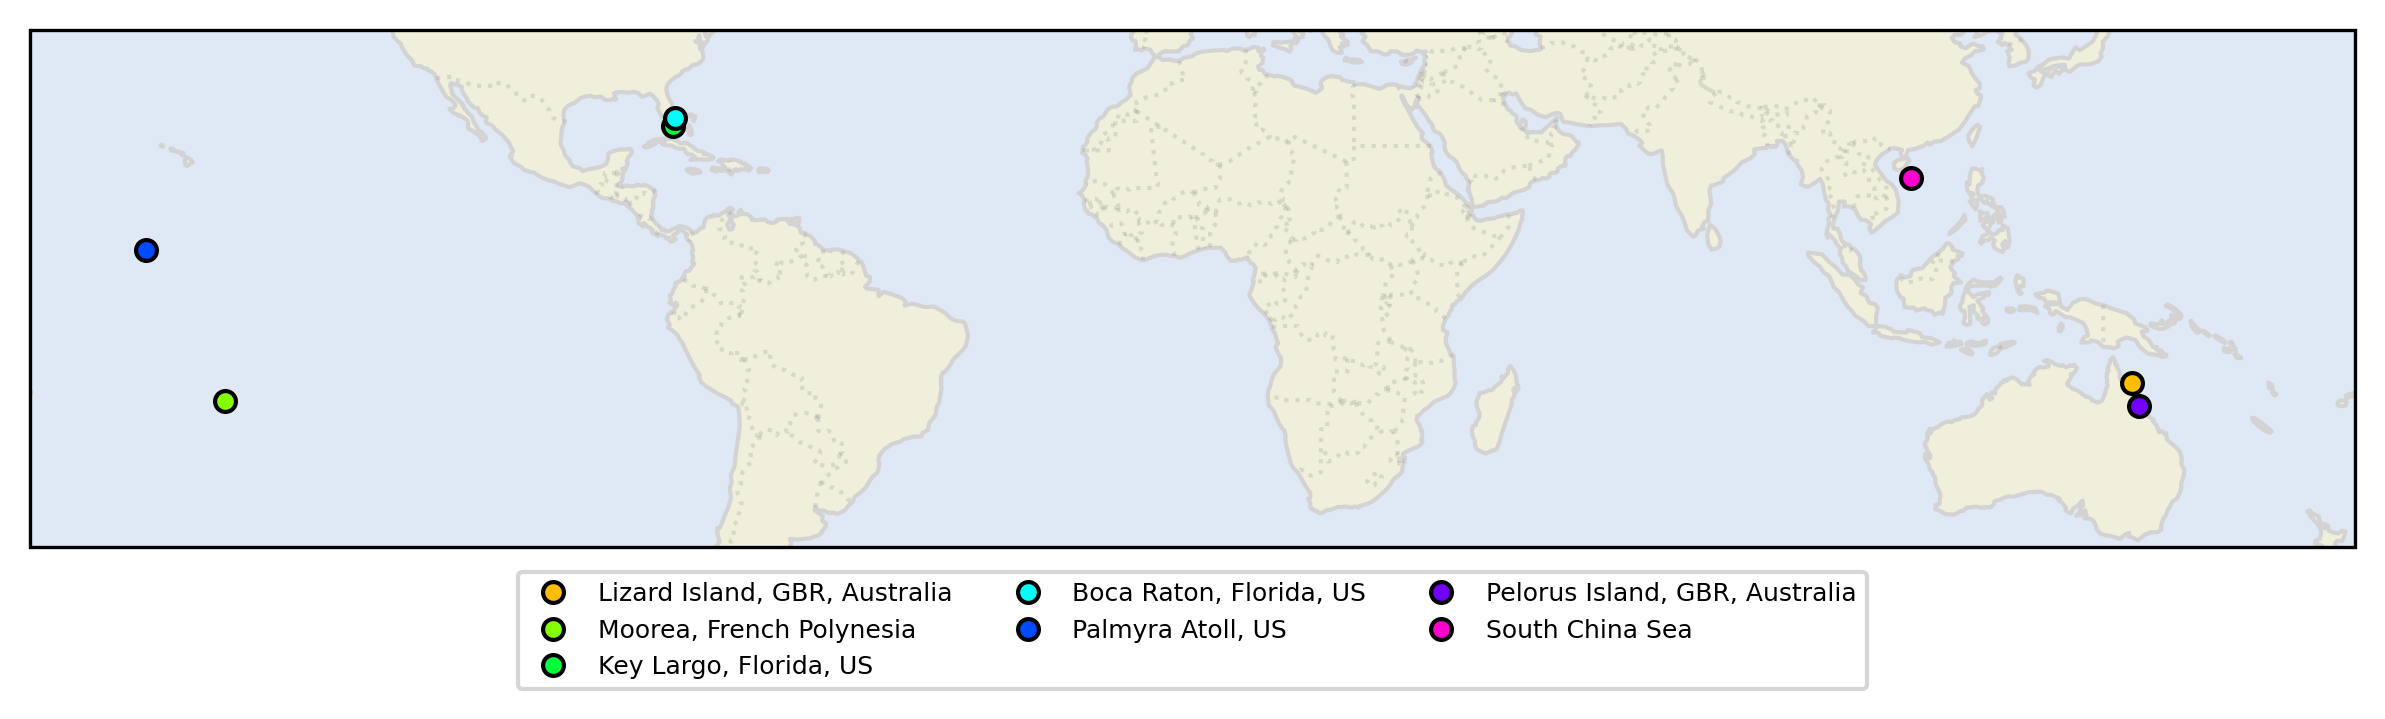

In [4]:
### plot spatial disribution of studies
# df.Location.unique()  # used to create locations.yaml
locations = read_yaml("data/locations.yaml")

# create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 20), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=300)
ax.set_extent([-180, 180, -40, 40], crs=ccrs.PlateCarree())

# add features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN, alpha=0.3)
ax.add_feature(cfeature.COASTLINE, edgecolor='lightgray')
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', alpha=0.2)

# add locations with colors
colors = sns.color_palette("hsv", len(locations))
for i, data in enumerate(locations):
    coords = data["coordinates"]
    ax.plot(coords["longitude"], coords["latitude"], 'o', markeredgecolor='k', markersize=5, color=colors[i], transform=ccrs.PlateCarree(), label=data["name"])

# add legend
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=len(locations)//2, fontsize=6);

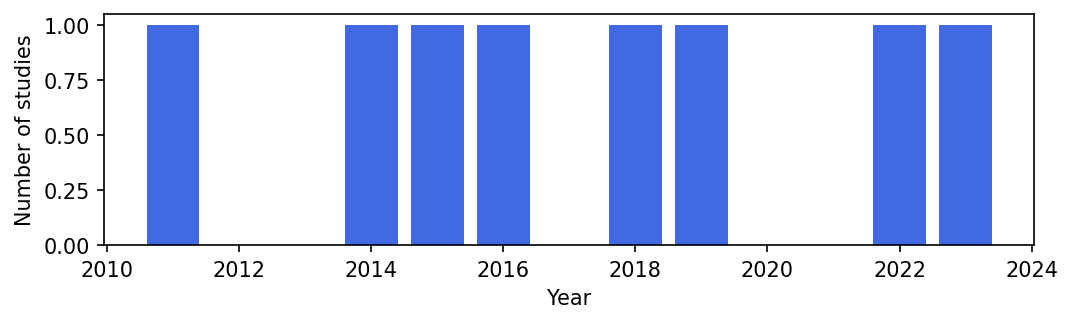

In [5]:
### plot temporal distribution of studies, breakdown by species
# create figure
fig, ax = plt.subplots(1, 1, figsize=(8, 2), dpi=150)

# drop na from Year columns
dates_df = df.dropna(subset=["Year"])

# count occurrences of each year
year_counts = dates_df['Year'].dt.year.value_counts().sort_index()

ax.bar(year_counts.index, year_counts.values, color='royalblue', width=0.8)
ax.set_ylabel("Number of studies")
ax.set_xlabel("Year");

In [6]:
df.columns

Index(['Notes', 'Secondary_check', 'Include', 'Authors', 'DOI', 'Year',
       'Species_types', 'Taxa', 'Location', 'Life_stages', 'pCO2_µatm',
       'pCO2_se_µatm', 'pCO2_sd_µatm', 'pH_NBS', 'pH_se_NBS', 'pH_sd_NBS',
       'pH_Total', 'pH_se_Total', 'pH_sd_Total', 'TA_µmol_kg-1',
       'TA_se_µmol_kg-1', 'TA_sd_µmol_kg-1', 'DIC_µmol/L', 'DIC_se_µmol/L',
       'DIC_sd_µmol/L', 'omegaCa', 'omegaCa_se', 'omegaCa_sd', 'omegaAr',
       'omegaAr_se', 'omegaAr_sd', 'CO32– µmol kg SW-1',
       'CO32– se_µmol kg SW-1', 'CO32– sd_µmol kg SW-1', 'HCO3- µmol kg SW-1',
       'HCO3- se_µmol kg SW-1', 'HCO3- sd_µmol kg SW-1', 'DO_mg_l-1',
       'DO_se_mg_l-1', 'DO_sd_mg_l-1', 'Irradiance_µmol_photons_m-2_s-1',
       'Irradiance_se_µmol_photons_m-2_s-1',
       'Irradiance_sd_µmol_photons_m-2_s-1',
       'Integrated_PAR_mol_quanta_m-2day-1',
       'Integrated_PAR_se_mol_quanta_m-2day-1', 'Temperature_ºC',
       'Temperature_se_ºC', 'Temperature_sd_ºC', 'Salinity_ppt',
       'Salinity_se_

In [7]:
df["pH_Total"]

0     8.003
1     7.980
2     7.698
3     7.694
4     8.003
      ...  
94      NaN
95      NaN
96      NaN
97      NaN
98      NaN
Name: pH_Total, Length: 63, dtype: float64

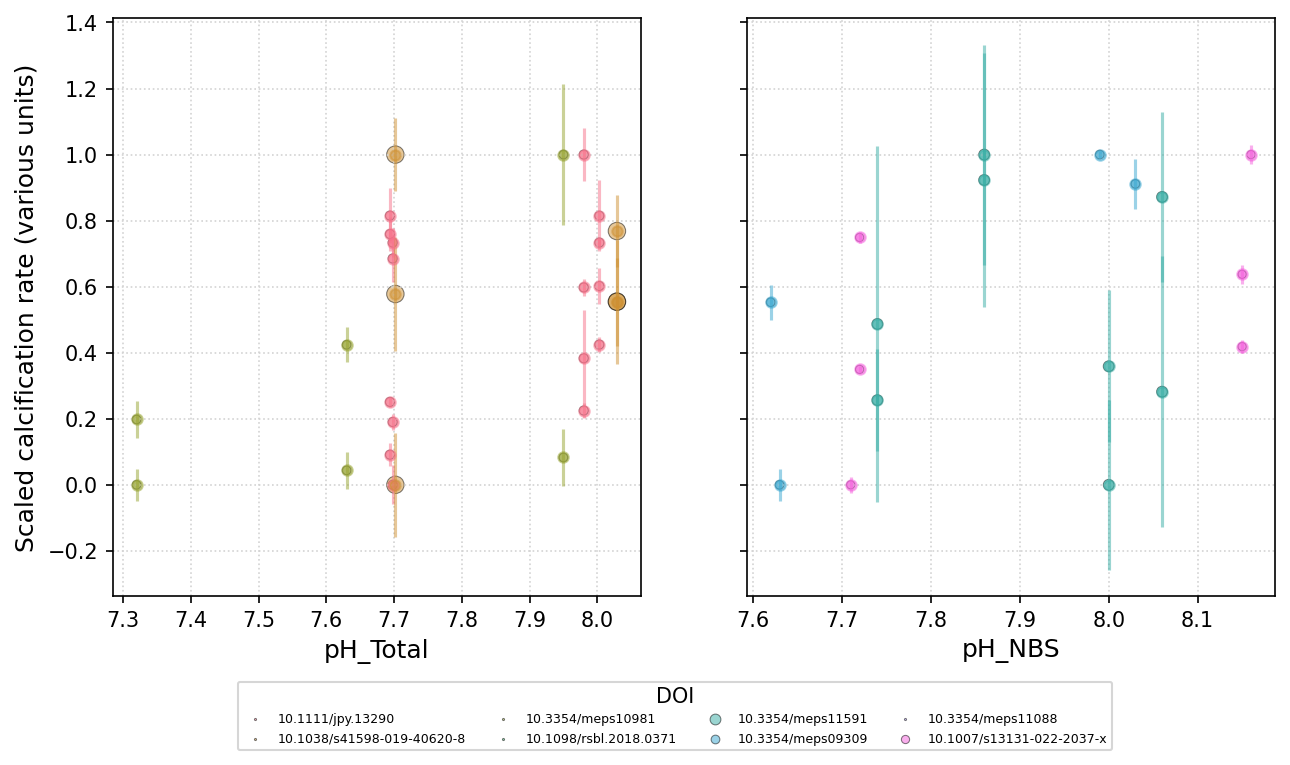

In [ ]:
### plot calcification rates against pH (whether Total or NBS)

# scale calcification rates for quick comparison
df['Calcification_scaled'] = df.groupby("DOI")['Calcification'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
# Compute range for each study
df['calc_range'] = df.groupby("DOI")['Calcification'].transform(lambda x: x.max() - x.min())

# calculate standard error on mean from standard deviation and sample size
df['se'] = df.apply(lambda row: row['Calcification_sd'] / row['n']**0.5 if pd.notnull(row['Calcification_sd']) and pd.notnull(row['n']) else np.nan, axis=1)
# update se column with any existing calcification se values
df['se'] = df['se'].combine_first(df['Calcification_se'])
# scale standard error using the same factor as calcification rates
df['se_scaled'] = df['se'] / df['calc_range']
# define marker size based on sample size
df['n'] = pd.to_numeric(df['n'], errors='coerce')  # Convert to numeric # TODO: account for 'M'
df['marker_size'] = df['n'].apply(lambda x: 10 + 60 * (x / df['n'].max()) if pd.notnull(x) else np.nan)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=150, sharey=True)
# generate a color palette
unique_dois = df['DOI'].unique()
palette = sns.color_palette("husl", len(unique_dois))
doi_color_map = dict(zip(unique_dois, palette))

for ax, pH_col, title in zip(axes, ['pH_Total', 'pH_NBS'], ['pH_Total', 'pH_NBS']):
    pH_df = df[[pH_col, 'Calcification_scaled', 'se_scaled', 'marker_size', 'DOI']].dropna()
    
    for doi in unique_dois:
        doi_df = pH_df[pH_df['DOI'] == doi]
        ax.errorbar(
            doi_df[pH_col], doi_df['Calcification_scaled'], yerr=doi_df['se_scaled'], 
            fmt='o', color=doi_color_map[doi], alpha=0.5, markersize=5
        )
        
        ax.scatter(
            doi_df[pH_col], doi_df['Calcification_scaled'], s=doi_df['marker_size'], 
            color=doi_color_map[doi], alpha=0.5, edgecolors='black', linewidth=0.5, label=doi
        )

    ax.set_xlabel(title, fontsize=12)
    ax.grid(True, c="lightgrey", ls=":")

axes[0].set_ylabel("Scaled calcification rate (various units)", fontsize=12)

# Add legend centered below both axes
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=len(unique_dois)//2, fontsize=6, title="DOI");

## Investigating fitting methods

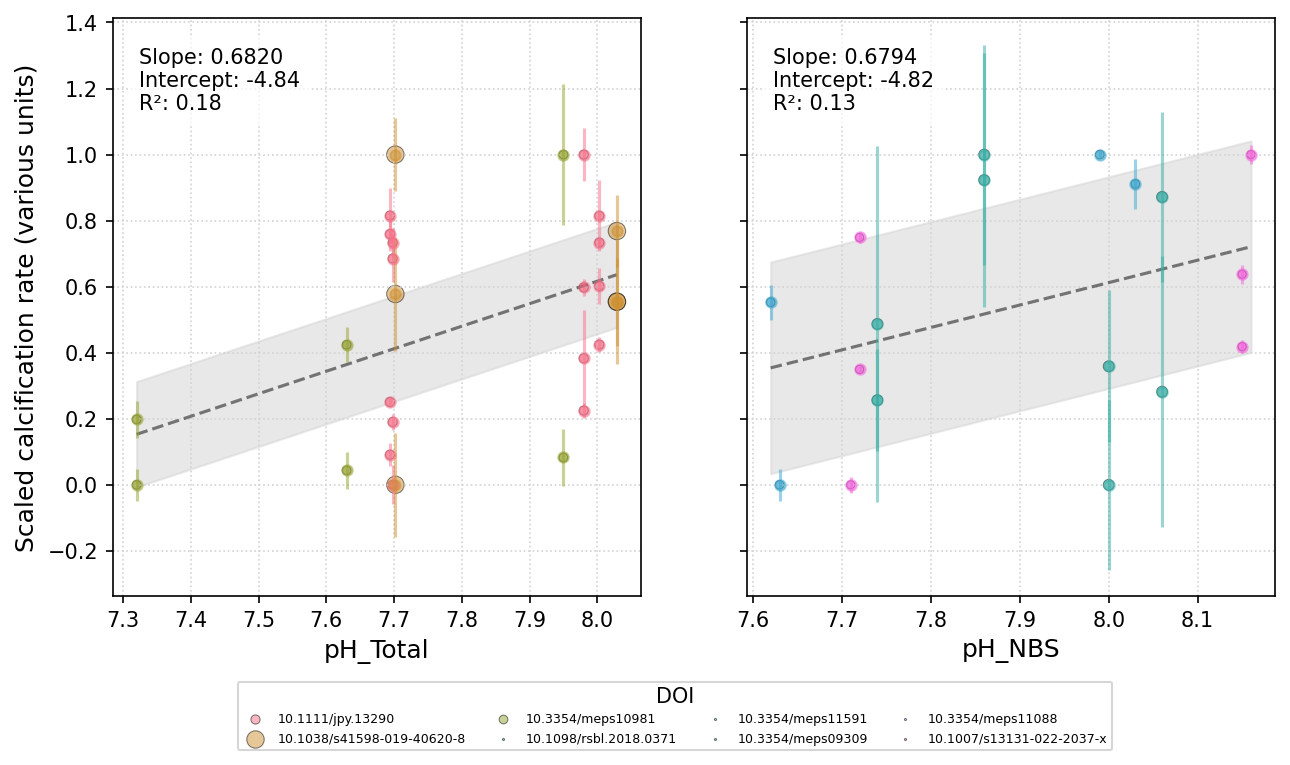

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=150, sharey=True)

# Generate a color palette
unique_dois = df['DOI'].unique()
palette = sns.color_palette("husl", len(unique_dois))
doi_color_map = dict(zip(unique_dois, palette))

# Empty lists to store handles and labels for the DOI legend
doi_handles, doi_labels = [], []

for ax, pH_col, title in zip(axes, ['pH_Total', 'pH_NBS'], ['pH_Total', 'pH_NBS']):
    pH_df = df[[pH_col, 'Calcification_scaled', 'se_scaled', 'marker_size', 'DOI']].dropna()
    
    # Least squares regression
    xs = np.linspace(pH_df[pH_col].min(), pH_df[pH_col].max(), 100)
    m, b = np.polyfit(pH_df[pH_col], pH_df['Calcification_scaled'], 1)
    r2 = np.corrcoef(pH_df[pH_col], pH_df['Calcification_scaled'])[0, 1]**2
    
    # Plot the regression line
    ax.plot(xs, m*xs + b, color='black', alpha=0.5, linestyle='--')
    
    # Add uncertainty shading
    ax.fill_between(xs, m*xs + b - 2*pH_df['se_scaled'].mean(), m*xs + b + 2*pH_df['se_scaled'].mean(), 
                    color='lightgray', alpha=0.5)
    
    # Add the slope, intercept, and R² to the plot as part of the legend
    ax.text(0.05, 0.95, f"Slope: {m:.4f}\nIntercept: {b:.2f}\nR²: {r2:.2f}", 
            transform=ax.transAxes, fontsize=10, verticalalignment='top', 
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))
    
    # Add DOI-specific error bars and scatter points
    for doi in unique_dois:
        doi_df = pH_df[pH_df['DOI'] == doi]
        ax.errorbar(
            doi_df[pH_col], doi_df['Calcification_scaled'], yerr=doi_df['se_scaled'], 
            fmt='o', color=doi_color_map[doi], alpha=0.5, markersize=5
        )
        
        # Add scatter points for DOIs
        scatter = ax.scatter(
            doi_df[pH_col], doi_df['Calcification_scaled'], s=doi_df['marker_size'], 
            color=doi_color_map[doi], alpha=0.5, edgecolors='black', linewidth=0.5
        )
        
        if doi not in doi_labels:   # add only if not already in legend
            doi_handles.append(scatter)
            doi_labels.append(doi)
    
    ax.set_xlabel(title, fontsize=12)
    ax.grid(True, c="lightgrey", ls=":")

axes[0].set_ylabel("Scaled calcification rate (various units)", fontsize=12)
fig.legend(doi_handles, doi_labels, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=len(unique_dois)//2, fontsize=6, title="DOI")

plt.show()


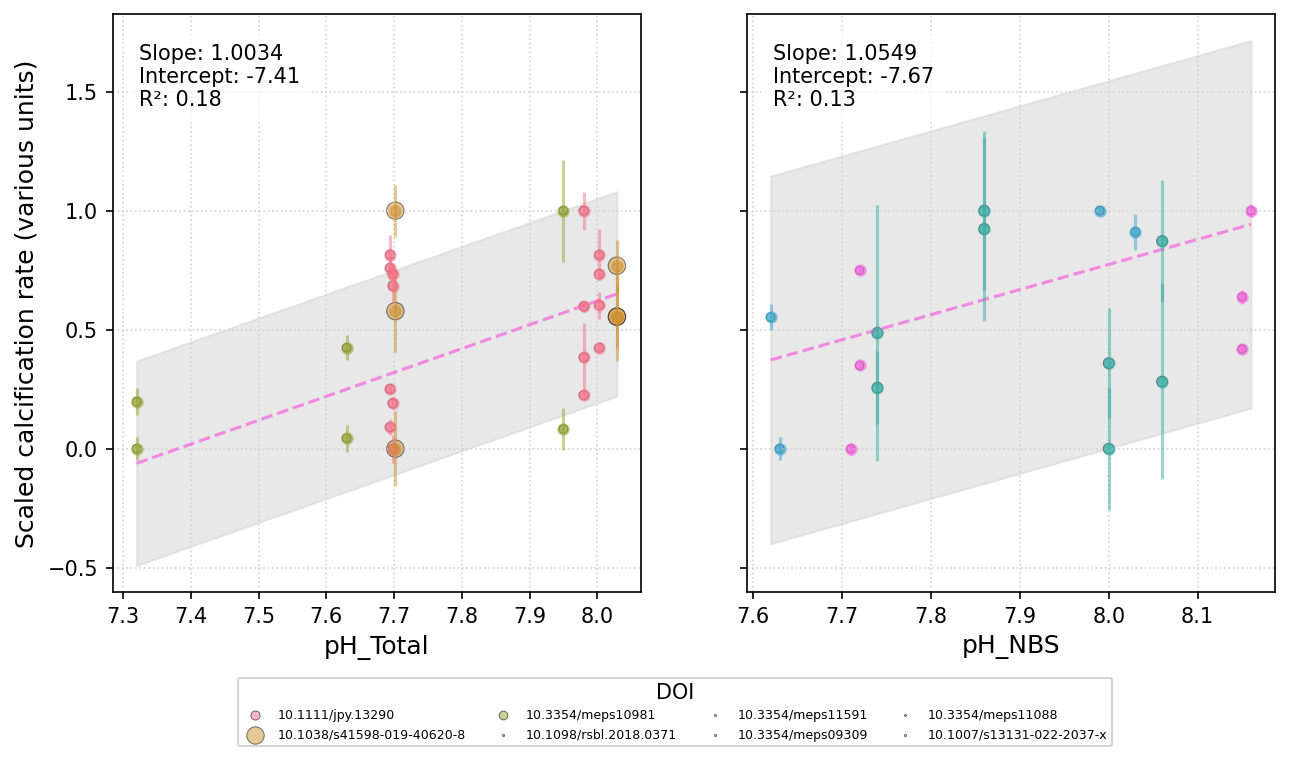

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=150, sharey=True)

# Generate a color palette
unique_dois = df['DOI'].unique()
palette = sns.color_palette("husl", len(unique_dois))
doi_color_map = dict(zip(unique_dois, palette))

for ax, pH_col, title in zip(axes, ['pH_Total', 'pH_NBS'], ['pH_Total', 'pH_NBS']):
    pH_df = df[[pH_col, 'Calcification_scaled', 'se_scaled', 'marker_size', 'DOI']].dropna()

    # Perform weighted least squares regression (WLS)
    X = sm.add_constant(pH_df[pH_col])  # Add intercept
    y = pH_df['Calcification_scaled']
    weights = 1 / pH_df['se_scaled']**2  # Weight by inverse variance (standard error squared)

    model = sm.WLS(y, X, weights=weights).fit()
    
    # Generate fitted values and confidence intervals
    xs = np.linspace(pH_df[pH_col].min(), pH_df[pH_col].max(), 100)
    Xs = sm.add_constant(xs)  # Add intercept for prediction
    fitted_values = model.predict(Xs)
    
    # get slope and intercept of fitted values
    b, m = model.params
    r2 = np.corrcoef(pH_df[pH_col], pH_df['Calcification_scaled'])[0, 1]**2
    
    
    # Add the slope, intercept, and R² to the plot as part of the legend
    ax.text(0.05, 0.95, f"Slope: {m:.4f}\nIntercept: {b:.2f}\nR²: {r2:.2f}", 
            transform=ax.transAxes, fontsize=10, verticalalignment='top', 
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))
    
    
    # Compute confidence intervals
    predicted_se = np.sqrt(np.diag(model.cov_params()))  # Standard errors of the coefficients
    confidence_interval = 1.96 * predicted_se[1]  # 95% confidence interval for slope (use the second coefficient)
    
    # Plot the fitted regression line and confidence interval
    ax.plot(xs, fitted_values, color=doi_color_map[doi], alpha=0.7, linestyle='--')
    ax.fill_between(xs, fitted_values - confidence_interval, fitted_values + confidence_interval,
                    color='lightgray', alpha=0.5)
    
    for doi in unique_dois:
        doi_df = pH_df[pH_df['DOI'] == doi]
        ax.errorbar(
            doi_df[pH_col], doi_df['Calcification_scaled'], yerr=doi_df['se_scaled'], 
            fmt='o', color=doi_color_map[doi], alpha=0.5, markersize=5
        )
        
        ax.scatter(
            doi_df[pH_col], doi_df['Calcification_scaled'], s=doi_df['marker_size'], 
            color=doi_color_map[doi], alpha=0.5, edgecolors='black', linewidth=0.5, label=doi
        )

    ax.set_xlabel(title, fontsize=12)
    ax.grid(True, c="lightgrey", ls=":")
    
    if doi not in doi_labels:   # add only if not already in legend
        doi_handles.append(scatter)
        doi_labels.append(doi)

axes[0].set_ylabel("Scaled calcification rate (various units)", fontsize=12)

# Add legend centered below both axes
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(doi_handles, doi_labels, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=len(unique_dois)//2, fontsize=6, title="DOI")

plt.show()
# N.B. accounting for uncertainty in measured values makes a major difference: compare the slopes


### Work in progress

In [ ]:
import statsmodels.api as sm

pH_col = 'pH_Total'
pH_df = df.dropna(subset=[pH_col, 'Calcification_scaled', 'se_scaled'])

X = sm.add_constant(pH_df[pH_col])  # add constant (intercept) term
y = pH_df['Calcification_scaled']   # dependent variable (response)

weights = 1 / 10*pH_df['se_scaled']**2  # calculate the weights (inverse of the squared standard errors). N.B. 10 is a heuristic scaling factor to prevent weight explosion
# adjust X and y for the weights (multiply by sqrt(weights))
X_weighted = X * np.sqrt(np.array(weights))[:, np.newaxis]
y_weighted = y * np.sqrt(np.array(weights))

model = sm.GLS(y_weighted, X_weighted).fit()
print(f"Results for {pH_col}:")
print(model.summary())

Results for pH_Total:
                                  GLS Regression Results                                 
Dep. Variable:     Calcification_scaled   R-squared (uncentered):                   0.779
Model:                              GLS   Adj. R-squared (uncentered):              0.764
Method:                   Least Squares   F-statistic:                              52.87
Date:                  Wed, 12 Feb 2025   Prob (F-statistic):                    1.47e-10
Time:                          00:24:20   Log-Likelihood:                          102.07
No. Observations:                    32   AIC:                                     -200.1
Df Residuals:                        30   BIC:                                     -197.2
Df Model:                             2                                                  
Covariance Type:              nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]

/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_68091/2698863054.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pH_df.loc[:, 'fitted_values'] = model.fittedvalues


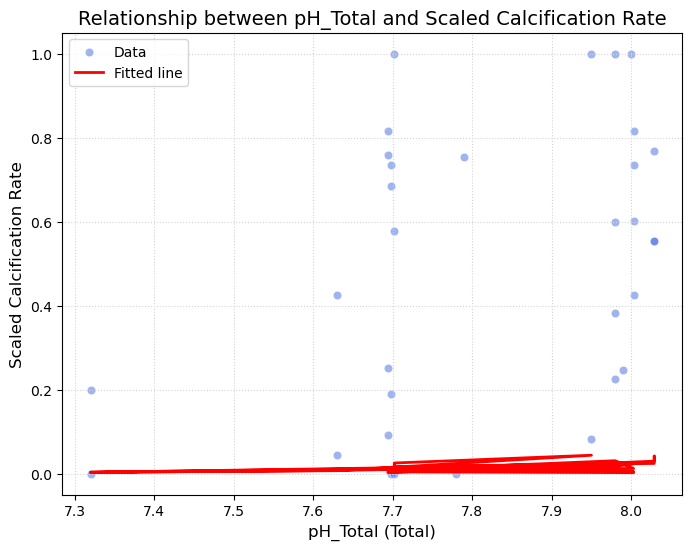

In [40]:
# Get the fitted values
pH_df.loc[:, 'fitted_values'] = model.fittedvalues

# Plotting the relationship
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pH_df[pH_col], y=pH_df['Calcification_scaled'], color='royalblue', alpha=0.5, label='Data')

# Plot the regression line (fitted values)
plt.plot(pH_df[pH_col], pH_df['fitted_values'], color='red', label='Fitted line', linewidth=2)

# Calculate the standard errors of the fitted values
predicted_se = np.sqrt(np.diag(model.cov_params()))

# Confidence interval (95%)
confidence_interval = 1.96 * predicted_se

# # Calculate the upper and lower bounds for the fitted values
# upper_bound = pH_df['fitted_values'] + confidence_interval
# lower_bound = pH_df['fitted_values'] - confidence_interval

# # Plot the confidence intervals as a shaded region
# plt.fill_between(pH_df[pH_col], lower_bound, upper_bound, color='red', alpha=0.2, label='95% Confidence Interval')

# Add labels and title
plt.xlabel(f'{pH_col} (Total)', fontsize=12)
plt.ylabel('Scaled Calcification Rate', fontsize=12)
plt.title(f'Relationship between {pH_col} and Scaled Calcification Rate', fontsize=14)
plt.legend()
plt.grid(True, linestyle=':', color='lightgrey')

# Show the plot
plt.show()